# w3Quiz3. Regression

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

___
Проанализируем данные опроса 4361 женщин из Ботсваны:
О каждой из них мы знаем:

- сколько детей она родила (признак **ceb**)
- возраст (**age**)
- длительность получения образования (**educ**)
- религиозная принадлежность (**religion**)
- идеальное, по её мнению, количество детей в семье (**idlnchld**)
- была ли она когда-нибудь замужем (**evermarr**)
- возраст первого замужества (**agefm**)
- длительность получения образования мужем (**heduc**)
- знает ли она о методах контрацепции (**knowmeth**)
- использует ли она методы контрацепции (**usemeth**)
- живёт ли она в городе (**urban**)
- есть ли у неё электричество, радио, телевизор и велосипед (**electric, radio, tv, bicycle**)

Давайте научимся оценивать количество детей ceb по остальным признакам.

In [2]:
df = pd.read_csv('data/botswana.tsv', sep='\t')
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


___
В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному.

Например, в признаке agefm пропуски стоят только там, где evermarr=0, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака NaN соответствует значению "не применимо".

В подобных случаях, когда признак $x_1$ на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:

- создать новый бинарный признак
$$
    x_1 =
    \begin{cases}
        1, & x_1=\text{не применимо;} \\
        0, & \text{иначе}
    \end{cases}
$$

- заменить "не применимо" в $x_1$ на произвольную константу c, которая среди других значений $x_1$ не встречается.

Теперь, когда мы построим регрессию на оба признака и получим модель вида:
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $$
на тех объектах, где $x_1$ было измерено, регрессионное уравнение примет вид:
$$ y = \beta_0 + \beta_1 x $$
а там, где $x_1$ было "не применимо", получится:
$$ y = \beta_0 + \beta_1 c + \beta_2 $$
Выбор c влияет только на значение и интерпретацию $\beta_2$, но не $\beta_1$.

Давайте используем этот метод для обработки пропусков в agefm и heduc.

- Создайте признак nevermarr, равный единице там, где в agefm пропуски.
- Удалите признак evermarr — в сумме с nevermarr он даёт константу, значит, в нашей матрице X будет мультиколлинеарность.
- Замените NaN в признаке agefm на $c_{agefm}=0$.
- У объектов, где nevermarr = 1, замените NaN в признаке heduc на $c_{heduc1}=-1$(ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки).

In [3]:
df['nevermarr'] = (df.agefm * 0).fillna(1)
df = df.drop('evermarr', axis=1)
df['agefm'] = df['agefm'].fillna(0)
df.heduc = df.heduc.where(df.nevermarr==0, other=-1)
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0.0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0.0


In [4]:
df.heduc.isna().value_counts()

False    4238
True      123
Name: heduc, dtype: int64

In [5]:
df.isna().sum()

ceb            0
age            0
educ           0
religion       0
idlnchld     120
knowmeth       7
usemeth       71
agefm          0
heduc        123
urban          0
electric       3
radio          2
tv             2
bicycle        3
nevermarr      0
dtype: int64

___
Избавимся от оставшихся пропусков.

Для признаков idlnchld, heduc и usemeth проведите операцию, аналогичную предыдущей: создайте индикаторы пропусков по этим признакам (idlnchld_noans, heduc_noans, usemeth_noans), замените пропуски на нехарактерные значения ($c_{idlnchld} = -1$, $c_{heduc_2} = -2$ (значение -1 мы уже использовали), $c_{usemeth} = -1$).

Остались только пропуски в признаках knowmeth, electric, radio, tv и bicycle. Их очень мало, так что удалите объекты, на которых их значения пропущены.

Какого размера теперь наша матрица данных? Умножьте количество строк на количество всех столбцов (включая отклик ceb).

In [7]:
df.idlnchld.unique()

array([ 4.,  2.,  3.,  5.,  6.,  1., nan,  0., 11., 10.,  8.,  7., 20.,
        9., 14., 17., 12., 15., 16., 13.])

In [8]:
df['idlnchld_noans'] = (df.idlnchld * 0).fillna(0.1)
df['heduc_noans'] = (df.heduc * 0).fillna(0.1)
df['usemeth_noans'] = (df.usemeth * 0).fillna(0.1)
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [9]:
df.idlnchld = df.idlnchld.fillna(-1)
df.heduc = df.heduc.fillna(-2)
df.usemeth = df.usemeth.fillna(-1)
df = df.dropna()
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print(df.shape)
df.shape[0] * df.shape[1]

(4348, 18)


78264

___
Постройте регрессию количества детей ceb на все имеющиеся признаки методом smf.ols, как в разобранном до этого примере. Какой получился коэффициент детерминации $R^2$
 ? Округлите до трёх знаков после десятичной точки.

In [11]:
print(' + '.join(df.columns.tolist()))

ceb + age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc + urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:45:26   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Text(0.5, 0, 'Residuals')

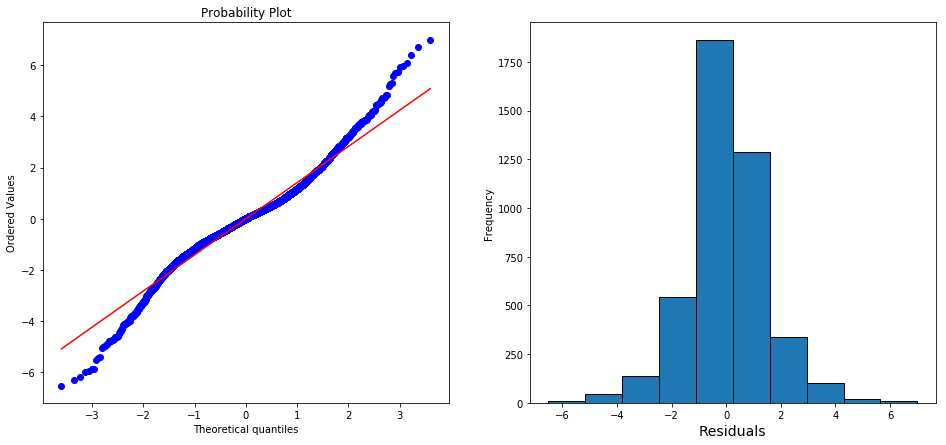

In [12]:
m1 = smf.ols(
    'ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + \
    heduc + urban + electric + radio + tv + bicycle + nevermarr + \
    idlnchld_noans + heduc_noans + usemeth_noans',
    data=df
)
#the_number_of_symbols_to_limit_the_line_length_according_to_PEP8_is________79
fitted = m1.fit()
print(fitted.summary())

plt.figure(figsize=(16,7))

plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)

plt.subplot(122)
#np.log(fitted.resid).plot.hist()
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)

___
Проверьте критерием Бройша-Пагана гомоскедастичность ошибки в построенной модели. Выполняется ли она?

Если ошибка гетероскедастична, перенастройте модель, сделав поправку Уайта типа HC1.

In [13]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(
    fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:45:45   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

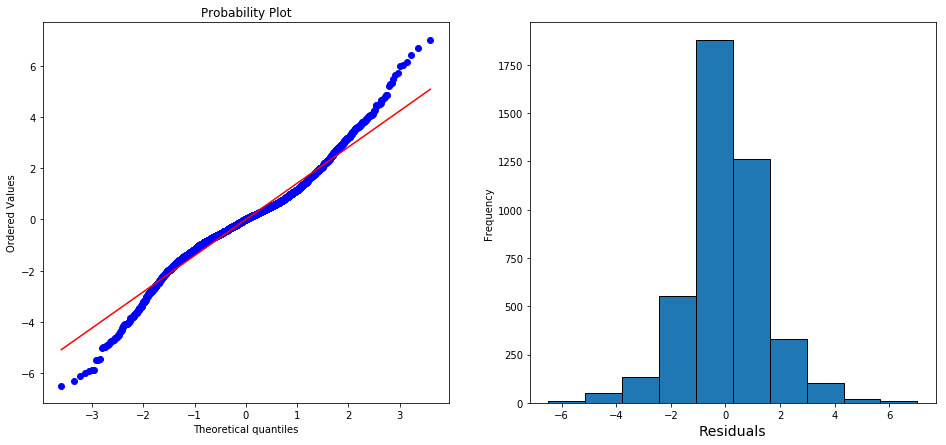

In [14]:
m2 = smf.ols(
    'ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + \
    heduc + urban + electric + bicycle + nevermarr + \
    idlnchld_noans + heduc_noans + usemeth_noans',
    data=df
)
#the_number_of_symbols_to_limit_the_line_length_according_to_PEP8_is________79
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize=(16,7))

plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)

plt.subplot(122)
#np.log(fitted.resid).plot.hist()
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

In [15]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(
    fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


In [16]:
m1.fit().compare_f_test(m2.fit())

(0.9192357784633435, 0.46723055472730823, 5.0)

___
Признак usemeth_noans значим по критерию Стьюдента, то есть, при его удалении модель значимо ухудшится. Но вообще-то отдельно его удалять нельзя: из-за того, что мы перекодировали пропуски в usemeth произвольно выбранным значением $c_{usemeth} = -1$, удалять usemeth_noans и usemeth можно только вместе.

Удалите из текущей модели usemeth_noans и usemeth. Проверьте критерием Фишера гипотезу о том, что качество модели не ухудшилось. Введите номер первой значащей цифры в достигаемом уровне значимости (например, если вы получили $5.5 \times 10^{-8}$ нужно ввести 8).

Если достигаемый уровень значимости получился маленький, верните удалённые признаки; если он достаточно велик, оставьте модель без usemeth и usemeth_noans.

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     396.4
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:46:30   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.262     -4.

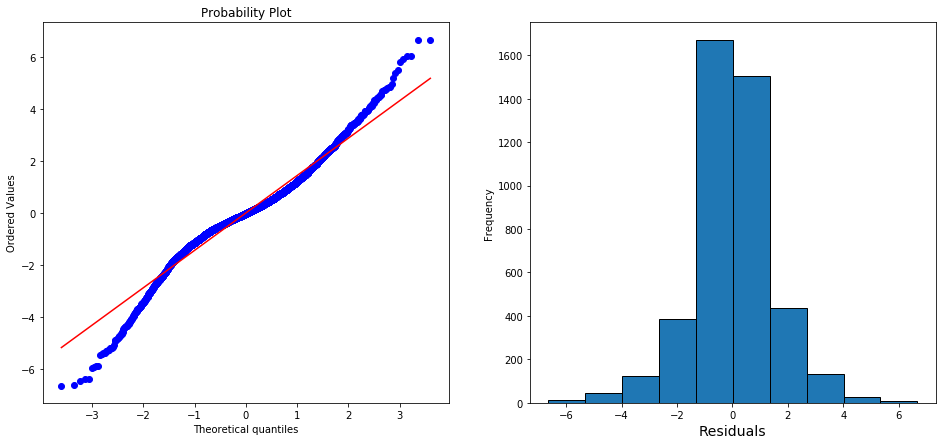

In [17]:
m3 = smf.ols(
    'ceb ~ age + educ + idlnchld + knowmeth + agefm + \
    heduc + urban + electric + bicycle + nevermarr + \
    idlnchld_noans + heduc_noans',
    data=df
)
#the_number_of_symbols_to_limit_the_line_length_according_to_PEP8_is________79
fitted = m3.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize=(16,7))

plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)

plt.subplot(122)
#np.log(fitted.resid).plot.hist()
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

In [18]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(
    fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


In [19]:
m2.fit().compare_f_test(m3.fit())

(92.89058230109713, 3.155200948040263e-40, 2.0)

___
Посмотрите на доверительные интервалы для коэффициентов итоговой модели (не забудьте использовать поправку Уайта, если есть гетероскедастичность ошибки) и выберите правильные выводы.

- [X] У женщин, никогда не выходивших замуж, при прочих равных в среднем на 2.3 ребёнка меньше (p<0.001, 95% доверительный интервал для разницы между средними — \[-2.6, -1.9\])
- [ ] Итоговая модель объясняет 63% вариации отклика
- [ ] У женщин, не знающих, какое количество детей идеально, в среднем на 0.66 ребёнка больше (p=0.002, 95% доверительный интервал — \[0.2, 1.1\])
- [ ] У женщин, не знающих, какое количество детей идеально, в среднем на
$$\beta_{idlnchld_noans}+ c_{idlnchld}\beta_{idlnchld} \approx 0.58 $$
детей больше
- [ ] У женщин, знакомых с методами контрацепции, при прочих равных в среднем на 0.6 ребёнка меньше (p=0.001, 95% доверительный интервал для разницы между средними — \[-0.9, -0.2\])
- [x] С увеличением возраста женщины на 1 год среднее количество детей возрастает на 0.17 (p<0.001, 95% доверительный интервал — \[0.16, 0.18\])

In [21]:
m4 = smf.ols(
    'ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + \
    heduc + urban + electric + bicycle + nevermarr + \
    idlnchld_noans + heduc_noans + usemeth_noans',
    data=df
)
fitted = m4.fit(cov_type='HC1')
print(fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Wed, 17 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:51:22   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.